In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import words
from gensim.models import KeyedVectors
import gensim.downloader as api
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os

from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('urlset/urlset.csv', error_bad_lines=False, encoding='latin1')
urls = df['domain'].to_numpy()
labels = df['label'].to_numpy()

d = set(words.words())
word_vectors = api.load("glove-wiki-gigaword-100")  

print('data loaded')

<ipython-input-2-09b475e720f2>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('urlset/urlset.csv', error_bad_lines=False, encoding='latin1')
b'Skipping line 18259: expected 14 fields, saw 15\nSkipping line 18273: expected 14 fields, saw 15\n'
<ipython-input-2-09b475e720f2>:1: DtypeWarning: Columns (1,2,3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('urlset/urlset.csv', error_bad_lines=False, encoding='latin1')


data loaded


In [3]:
common_words = set()
common_words_df = pd.read_csv('google-10000-english.txt', sep=' ')
for word in list(common_words_df.to_numpy().flatten()[:5000]):
    common_words.add(word)

In [4]:
DATASET_PCT = 0.1

#Preprocess & randomize data, this is so we avoid the first n urls all being labelled 1
urls_short = []
labels_short = []
for u in range(len(urls)):
    n = np.random.rand()
    if n < DATASET_PCT:
        urls_short.append(urls[u])
        labels_short.append(labels[u])
    
label_dict= {}
for i in range(len(urls_short)):
    label_dict[urls_short[i]] = labels_short[i]
    
# map urls to 
node_index = {}
index_node = {}
label_index = {}
i = 0
for n in urls_short:
    node_index[n] = i
    index_node[i] = n
    if (n in label_dict) and (not np.isnan(label_dict[n])):
        label_index[i] = int(label_dict[n])
    else:
        label_index[i] = 0
    i+=1

In [5]:
def find_words(subs):
    
    i = 0
    j = 4
    w = set()
    for s in subs:
        if len(s) < 4:
            continue
        for i in range(len(s) - 1):
            for j in range(3, len(s) - i):
                #print(s[i:i+j+1], s[i:i+j+1] in d)
                if s[i:i+j+1] in d and s[i:i+j+1] in common_words:
                    w.add(s[i:i+j+1])
    return w

#dict of url to similar words
sim_words_dict = {}

print('Finding Similar Words')
t=1
for i in range(len(urls_short)):
    if i > (len(urls_short))/(10/t):
        print(f'{t*10}%', end= ' ')
        t+=1
    url = str(urls_short[i])
    
    #finds the related words
    sub_domains = url.split('/')[1:]
    w = find_words(sub_domains)
    
    words = set(w)
    #will go through and find the similar words for each word in w
    for j in w:
        j = str(j)
        try:
            similar = set((np.asarray(word_vectors.most_similar([j], topn=3, restrict_vocab=None)).T)[0])
        except:
            #set it up as an empty set if there are no similar words
            similar = set()
        
        words |= similar
        
    sim_words_dict[node_index[url]] = words

Finding Similar Words
10% 20% 30% 40% 50% 60% 70% 80% 90% 

In [6]:
# Define our graph with connections between urls that have similar words
G = nx.Graph()
t = 1

for i in range(len(urls_short)-1):
    for j in range(i+1, len(urls_short)):
        if i*j > (len(urls_short)**2)/(10/t):
            print(f'{t*10}%', end= ' ')
            t+=1
        
        url1 = node_index[urls_short[i]]
        url2 = node_index[urls_short[j]]
        
        if url1 == url2:
            continue
        
        if url1 not in G:
            G.add_node(url1)
        if url2 not in G:
            G.add_node(url2)

        if len(sim_words_dict[url1].intersection(sim_words_dict[url2])) > 5 and (not G.has_edge(url1, url2)):
            G.add_edge(url1, url2, weight = len(sim_words_dict[url1].intersection(sim_words_dict[url2]))/100)


10% 20% 30% 40% 50% 60% 70% 80% 90% 

In [7]:
nx.write_adjlist(G, 'urls_only.adjlist')

In [8]:
word_dict = set()
for n in sim_words_dict:
    for w in sim_words_dict[n]:
        word_dict.add(w)

sim_word_vecs = {}
for n in G.nodes:
    l = []
    for w in word_dict:
        # create a vector for each node with 1s for each similar word
        if w in sim_words_dict[n]:
            l.append(1)
        else:
            l.append(0)
    sim_word_vecs[n] = l

fs = []
nodes = []

for n in G.nodes:
    nodes.append(n)
    fs.append(sim_word_vecs[n])

features = pd.DataFrame(fs, index=nodes)

SG = StellarGraph.from_networkx(G, node_features = features)
print(SG.info())

StellarGraph: Undirected multigraph
 Nodes: 9812, Edges: 239213

 Node types:
  default: [9812]
    Features: float32 vector, length 3867
    Edge types: default-default->default

 Edge types:
    default-default->default: [239213]
        Weights: range=[0.06, 0.6], mean=0.101075, std=0.0303954
        Features: none


In [9]:
features.to_csv('features.csv')

In [10]:
print(features.shape)


(9812, 3867)


In [11]:
url_set = pd.Series(label_index)
url_set.to_csv('url_set.csv')
train_nodes, test_nodes = model_selection.train_test_split(url_set, train_size=len(url_set)//5, test_size=None, stratify=url_set)
val_nodes, test_nodes = model_selection.train_test_split(test_nodes, train_size=len(url_set)//5, test_size=None, stratify=test_nodes)

In [12]:
train_nodes.value_counts().to_frame()

,0
1,982
0,980


In [51]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [14]:
x_train = []
y_train = []
for ind in list(train_nodes.keys()):
    x_train.append(sim_word_vecs[ind])
    y_train.append(label_index[ind])
    
    
x_test = []
y_test = []
for ind in list(test_nodes.keys()):
    x_test.append(sim_word_vecs[ind])
    y_test.append(label_index[ind])
    
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
print(x_train.shape)
print(y_train.shape)
print(sum(y_train))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test))

(1962, 3867)
(1962,)
982
(5888, 3867)
(5888,)
2946


# Baseline Model

In [15]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [16]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [17]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [18]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

num_classes=2
num_features = x_train.shape[1]
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 3867)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 64)           267436      ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 64)           8832        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 64)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [19]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
7/7 [==============================] - 4s 173ms/step - loss: 1.5699 - acc: 0.5051 - val_loss: 0.6524 - val_acc: 0.6305
Epoch 2/300
7/7 [==============================] - 0s 38ms/step - loss: 1.0413 - acc: 0.6089 - val_loss: 0.5987 - val_acc: 0.6000
Epoch 3/300
7/7 [==============================] - 0s 50ms/step - loss: 0.8642 - acc: 0.6521 - val_loss: 0.5473 - val_acc: 0.6847
Epoch 4/300
7/7 [==============================] - 0s 54ms/step - loss: 0.7491 - acc: 0.6437 - val_loss: 0.6799 - val_acc: 0.5898
Epoch 5/300
7/7 [==============================] - 0s 36ms/step - loss: 0.6478 - acc: 0.7121 - val_loss: 2.5518 - val_acc: 0.5729
Epoch 6/300
7/7 [==============================] - 0s 40ms/step - loss: 0.5832 - acc: 0.6935 - val_loss: 1.2285 - val_acc: 0.5729
Epoch 7/300
7/7 [==============================] - 0s 39ms/step - loss: 0.5465 - acc: 0.7313 - val_loss: 0.7662 - val_acc: 0.5864
Epoch 8/300
7/7 [==============================] - 0s 31ms/step - loss: 0.5021 - acc: 0.7

7/7 [==============================] - 0s 34ms/step - loss: 0.3542 - acc: 0.8086 - val_loss: 0.4304 - val_acc: 0.7559
Epoch 64/300
7/7 [==============================] - 0s 42ms/step - loss: 0.3411 - acc: 0.8146 - val_loss: 0.4221 - val_acc: 0.7492
Epoch 65/300
7/7 [==============================] - 0s 41ms/step - loss: 0.3411 - acc: 0.8092 - val_loss: 0.4386 - val_acc: 0.7424
Epoch 66/300
7/7 [==============================] - 0s 32ms/step - loss: 0.3510 - acc: 0.8086 - val_loss: 0.4337 - val_acc: 0.7525
Epoch 67/300
7/7 [==============================] - 0s 33ms/step - loss: 0.3447 - acc: 0.8032 - val_loss: 0.4406 - val_acc: 0.7458
Epoch 68/300
7/7 [==============================] - 0s 31ms/step - loss: 0.3397 - acc: 0.8110 - val_loss: 0.4459 - val_acc: 0.7424
Epoch 69/300
7/7 [==============================] - 0s 36ms/step - loss: 0.3354 - acc: 0.8128 - val_loss: 0.4529 - val_acc: 0.7458
Epoch 70/300
7/7 [==============================] - 0s 39ms/step - loss: 0.3500 - acc: 0.8056 - 

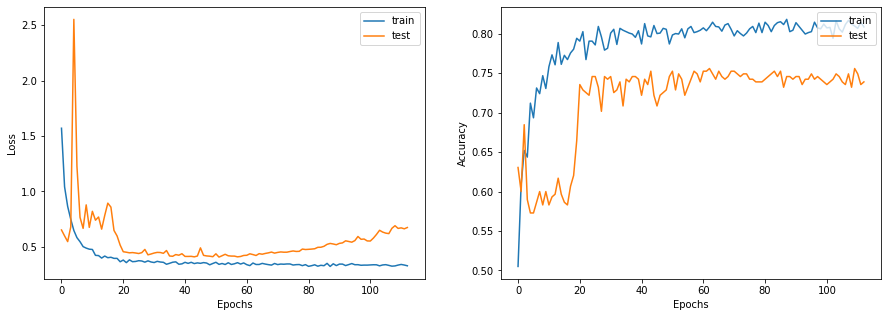

In [20]:
display_learning_curves(history)

In [21]:
x,test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {test_accuracy * 100}%")

Test accuracy: 77.4286687374115%


# GCN Model

In [39]:
edges = []
weights = []
for e in G.edges():
    edges.append(list(e))
    weights.append(G.get_edge_data(e[0], e[1])['weight'])
    
edges = np.asarray(edges).T
edge_weights = np.asarray(weights)
node_features = features.to_numpy().astype('float64')
print(edges.shape)
print(edge_weights.shape)
print(node_features.shape)
graph_info = (node_features, edges, edge_weights)


(2, 239213)
(239213,)
(9812, 3867)


In [63]:
NUM_NODES = node_features.shape[0]
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = NUM_NODES
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [64]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [65]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=2,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.13376579 -0.02159869]
 [-0.09654604 -0.06911886]
 [-0.11216924  0.03351104]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (9812, 32)                140428    
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (9812, 32)                2368      
                                                                 
 logits (Dense)              multiple           

In [68]:
x_train = np.asarray(train_nodes.keys())
history = run_experiment(gnn_model, x_train, y_train)

[ 892 2863 7267 ...   21 4283 8716]
Epoch 1/300
7/7 [==============================] - 49s 4s/step - loss: 0.7938 - acc: 0.5189 - val_loss: 0.6809 - val_acc: 0.5729
Epoch 2/300
7/7 [==============================] - 8s 1s/step - loss: 0.7305 - acc: 0.5249 - val_loss: 0.6778 - val_acc: 0.5729
Epoch 3/300
7/7 [==============================] - 8s 1s/step - loss: 0.7020 - acc: 0.5375 - val_loss: 0.6749 - val_acc: 0.5729
Epoch 4/300
7/7 [==============================] - 8s 1s/step - loss: 0.6894 - acc: 0.5393 - val_loss: 0.6693 - val_acc: 0.5729
Epoch 5/300
7/7 [==============================] - 8s 1s/step - loss: 0.6786 - acc: 0.5597 - val_loss: 0.6493 - val_acc: 0.5729
Epoch 6/300
7/7 [==============================] - 8s 1s/step - loss: 0.6591 - acc: 0.5927 - val_loss: 0.6346 - val_acc: 0.5729
Epoch 7/300
7/7 [==============================] - 8s 1s/step - loss: 0.6414 - acc: 0.6137 - val_loss: 0.6051 - val_acc: 0.5763
Epoch 8/300
7/7 [==============================] - 8s 1s/step - los

7/7 [==============================] - 8s 1s/step - loss: 0.3427 - acc: 0.8140 - val_loss: 0.7562 - val_acc: 0.7119
Epoch 65/300
7/7 [==============================] - 8s 1s/step - loss: 0.3313 - acc: 0.8140 - val_loss: 0.8374 - val_acc: 0.7153
Epoch 66/300
7/7 [==============================] - 8s 1s/step - loss: 0.3381 - acc: 0.8098 - val_loss: 0.6184 - val_acc: 0.7186
Epoch 67/300
7/7 [==============================] - 8s 1s/step - loss: 0.3332 - acc: 0.8062 - val_loss: 0.4363 - val_acc: 0.7492
Epoch 68/300
7/7 [==============================] - 8s 1s/step - loss: 0.3323 - acc: 0.8134 - val_loss: 0.4673 - val_acc: 0.7492
Epoch 69/300
7/7 [==============================] - 8s 1s/step - loss: 0.3326 - acc: 0.8134 - val_loss: 0.4388 - val_acc: 0.7593
Epoch 70/300
7/7 [==============================] - 8s 1s/step - loss: 0.3360 - acc: 0.8128 - val_loss: 0.4509 - val_acc: 0.7492
Epoch 71/300
7/7 [==============================] - 8s 1s/step - loss: 0.3370 - acc: 0.8056 - val_loss: 0.4807

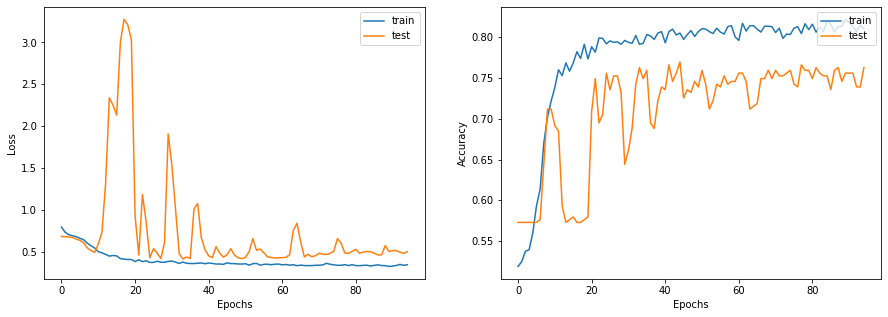

In [69]:
display_learning_curves(history)

In [70]:
x_test = np.asarray(test_nodes.keys())
x,test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {test_accuracy * 100}%")

Test accuracy: 76.4775812625885%
